#### LOAD LIBRARIES

In [12]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import sys

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_8516/81850615.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_8516/81850615.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### DEFINE PROBLEM PARAMETERS

In [13]:
# Define universal constants:
N_AVOG = 6.022141E+23  # [-]
N_BOLT = 1.380649E-23  # [-]

# Define geometrical parameters:
RADIUS = 1.00E-05  # [m]
LENGTH = 1.00E-03  # [m]

# Define sources intensity:
FISSION_RATE = 3.00E+19                 # Per T [fissions/s] per c [fissions/m^3 s]
#q''' = 3.21e-11                       #[W/m^3]
#rho = 11040                           #[Kg/m^3]
#Cp = 400                              #[J/(Kg K)]
FISSION_HEAT = 7.27E-18                 #[K/fissions]    = q'''/(rho Cp)
FISSION_YIELD = 0.24E+00                #Xenon [at/fissions]  
SOURCE_T = FISSION_RATE * FISSION_HEAT   #[K/s]
SOURCE_C = FISSION_RATE * FISSION_YIELD  #[atm / (m^3 s)]

# Define temperatur diffusion coefficient and forcing dimensionless group:
#k = 2.5 E-05                          #[W/(m K)]
ALPHA_T = 5.00E-07  # [m^2 / s]        # = k/(rho Cp)
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T  # [ - ]

# Define reference temperature, concentration and linear diffusion parameters:
T_BC, T_IC = 2.00E+03, 2.00E+03  # [K]
C_BC, C_IC = 0.00E+00, 0.00E+00  # [atm / m^3]

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T):
    return 5.0e-08 * np.exp(-40262.0 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2));


La soluzione analitica della temperatura ottenuta tramite il suo sviluppo n serie:
$$
\begin{equation}
T_{\infty} =\frac{qL^2}{2 \alpha} (1 - z^2) + T_{IC}
\end{equation}
$$

In [14]:
Dx = 5.0e-08 * np.exp(-40262.0 / 2000)/(RADIUS**2)
Dy = 5.0e-08 * np.exp(-40262.0 / 2000)/(RADIUS**2)
Dz = 5.0e-08 * np.exp(-40262.0 / 2000)/(LENGTH**2)

print(rf'Dx = {Dx}')
print(rf'Dy = {Dy}')
print(rf'Dz = {Dz}')

Dx = 9.040402966767942e-07
Dy = 9.040402966767942e-07
Dz = 9.040402966767943e-11


#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [15]:
# Load coordinates:
coordinates_Px = FFvector_fread('vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

#### IMPORT FINITE ELEMENT ESSENTIALS

In [16]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('ww_mm_Pq.btxt')

# Compute volume of the domain:
volume = mass_Px.dot(np.ones(sFO_Px)).dot(np.ones(sFO_Px))

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('ww_dy_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdz_C = project_Pq.dot(FFmatrix_fread('ww_dz_Px_Pq.btxt')[:, mask_in_C])

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(weights_Pq[:, None]))
inte_C = mass_Px.dot(np.ones((sFO_Px)))[mask_in_C] / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / LENGTH**2 * weights_Pq[:, None]))

#### IMPLEMENT FULLY IMPLICID FORWARD EULER FOR THE CONCENTRATION ONLY

In [17]:
# Initialise temperature and concentration solution containing the deviation from the initial condition:
sol_new_C = np.zeros((sFO_Px, N_ITER+1)) 
average_C = np.zeros(N_ITER)             #create to save data

# Crea o sovrascrivi il file CSV all'inizio
with open('Sensitivity/12Layers_5Refine_0.75Transition_4Center.csv', 'w') as f:
    f.write('Time (s),Average dC (atm/m^3)\n')  # Intestazione delle colonne

for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    print('Current time:', cur_time, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average dC:', average_C[ii], 'atm/m^3\n')

    # Salva i dati correnti nel file CSV
    with open('Sensitivity/12Layers_5Refine_0.75Transition_4Center.csv', 'a') as f:
        f.write(f'{cur_time},{average_C[ii]}\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs = mass_C + TIME_DELTA * stiff_C
    cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + TIME_DELTA * (SOURCE_C * forc_C)

    # Compute perturbation from the initial temperature and concentration in the interior of the domain:
    sol_new_C[mask_in_C, ii+1], _ = linalg.bicgstab(cur_lhs, cur_rhs)
    #sol_new_C[mask_in_C, ii+1] = linalg.spsolve(cur_lhs, cur_rhs)
    #sol_new_C[mask_in_C, ii+1], _ = linalg.gmres(cur_lhs, cur_rhs)

# Print final time and final average temperature and concentration:
final_time = N_ITER * TIME_DELTA
final_average_dC = mass_Px.dot(sol_new_C[:, -1]).dot(np.ones((sFO_Px, 1)))[0] / volume

print('Final time:', final_time, 's')
print('Average dC:', final_average_dC, 'atm/m^3')

# Aggiungi i dati finali al file CSV
with open('Sensitivity/12Layers_5Refine_0.75Transition_4Center.csv', 'a') as f:
    f.write(f'{final_time},{final_average_dC}\n')

Current time: 0.0 s
Average dC: 0.0 atm/m^3

Current time: 10000.0 s
Average dC: 4.717466274708788e+22 atm/m^3

Current time: 20000.0 s
Average dC: 8.366561085164426e+22 atm/m^3

Current time: 30000.0 s
Average dC: 1.131047114777287e+23 atm/m^3

Current time: 40000.0 s
Average dC: 1.3736475263806239e+23 atm/m^3

Current time: 50000.0 s
Average dC: 1.5763944843456268e+23 atm/m^3

Current time: 60000.0 s
Average dC: 1.747670368221566e+23 atm/m^3

Current time: 70000.0 s
Average dC: 1.893670873302615e+23 atm/m^3

Current time: 80000.0 s
Average dC: 2.019113296829365e+23 atm/m^3

Current time: 90000.0 s
Average dC: 2.127659337479025e+23 atm/m^3

Current time: 100000.0 s
Average dC: 2.2221897608925508e+23 atm/m^3

Current time: 110000.0 s
Average dC: 2.3049984085186524e+23 atm/m^3

Current time: 120000.0 s
Average dC: 2.3779267988086222e+23 atm/m^3

Current time: 130000.0 s
Average dC: 2.4424666138015505e+23 atm/m^3

Current time: 140000.0 s
Average dC: 2.4998341179577182e+23 atm/m^3

Curre

OpenFOAM average concentration (@ final time): 3.109299e+23 atm/m^3
Python average concentration (@ final time): 3.087628882814206e+23 atm/m^3
Relative error (@ final time): 0.69695%


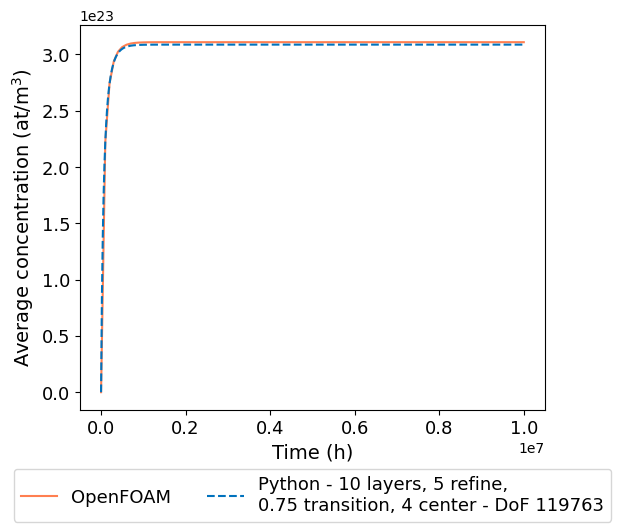

In [21]:
OpenFOAM=np.loadtxt("volFieldValue.dat")     #HF in OpenFOAM
print('OpenFOAM average concentration (@ final time):', OpenFOAM[-1,1], 'atm/m^3')
df = pd.read_csv('Sensitivity/12Layers_5Refine_0.75Transition_4Center.csv')

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.plot(OpenFOAM[:,0],OpenFOAM[:,1], color='#FF7F50', label='OpenFOAM', linewidth=1.5)
#ax1.plot(df_1['Time (s)'], df_1['Average dC (atm/m^3)'],color='#884DA7', label='Python - 20 layers, 3 refine, 0.75 transition, 4 center', linewidth=1.5)
#ax1.plot(df_2['Time (s)'], df_2['Average dC (atm/m^3)'], '--',color='#0072bd',markevery=100, label='Python - 16 layers, 3 refine, 0.75 transition, 4 center', linewidth=1.5)
#ax1.plot(df_3['Time (s)'], df_3['Average dC (atm/m^3)'], color='#00A86B', label='Python - 10 layers, 6 refine, 0.75 transition, 2 center', linewidth=1.5)
#ax1.plot(df_4['Time (s)'], df_4['Average dC (atm/m^3)'], color='#884DA7', label='Python - 16 layers, 5 refine, 0.5 transition, 2 center', linewidth=1.5)
#ax1.plot(df_5['Time (s)'], df_5['Average dC (atm/m^3)'], color='#884DA7', label='Python - 10 layers, 5 refine, 0.5 transition, 2 center', linewidth=1.5)
ax1.plot(df['Time (s)'], df['Average dC (atm/m^3)'], '--',color='#0072bd', label='Python - 10 layers, 5 refine,\n0.75 transition, 4 center - DoF 119763', linewidth=1.5)

ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Average concentration (at/m$^3$)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)


ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)


print('Python average concentration (@ final time):', df['Average dC (atm/m^3)'].iloc[-1], 'atm/m^3')
errore_end= (np.abs((OpenFOAM[-1,1]-df['Average dC (atm/m^3)'].iloc[-1]))/(OpenFOAM[-1,1]))*100
print(rf'Relative error (@ final time): {errore_end:.5f}%')

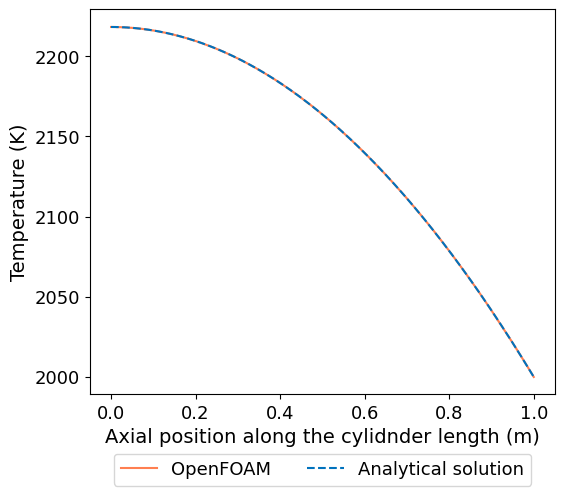

In [22]:
OpenFOAM=pd.read_csv("Temperature_along_z.csv")     

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1,1000), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2, '--',label = 'Analytical solution', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)
